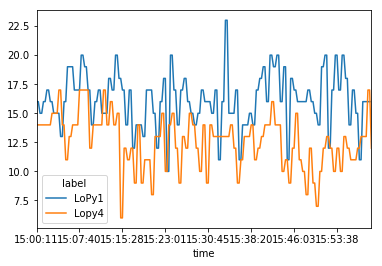

In [654]:
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import normalize, StandardScaler
import pandas as pd
from statistics import mean, median, mode, stdev, variance
from scipy import stats


client = MongoClient('localhost',27017)
lopy1Wifi = client.SMART.WiFi_Data_Lopy1
lopy2Wifi = client.SMART.WiFi_Data_Lopy2
lopy3Wifi = client.SMART.WiFi_Data_Lopy3
lopy4Wifi = client.SMART.WiFi_Data_Lopy4
lopy5Wifi = client.SMART.WiFi_Data_Lopy5
lopy6Wifi = client.SMART.WiFi_Data_Lopy6
rpi1Wifi = client.SMART.WiFi_Data_Rpi1

numNets1 = []
times1 = []
numNets2 = []
times2 = []
rssi1 = []
rssi2 = []

for item in lopy1Wifi.find({ '$and' : [{'Time': {'$gt': '20190304T150000'}}, {'Time': {'$lte': '20190304T160000'}}]}):
    numNets1.append(len(item['Networks']))
    
    pos = item['Networks'].index('TelstraD293DF') if 'TelstraD293DF' in item['Networks'] else None
    if pos != None:
        rssi1.append(item['Signal Strengths'][pos])
    time1 = item['Time'][9:]
    time1 = ':'.join(time1[i:i+2] for i in range(0, len(time1), 2))
    times1.append(time1)
#print(rssi1)
for item in lopy6Wifi.find({ '$and' : [{'Time': {'$gt': '20190304T150000'}}, {'Time': {'$lte': '20190304T160000'}}]}):
    numNets2.append(len(item['Networks']))
    pos = item['Networks'].index('TelstraD293DF') if 'TelstraD293DF' in item['Networks'] else None
    if pos != None:
        rssi2.append(item['Signal Strengths'][pos])
    time2 = item['Time'][9:]
    time2 = ':'.join(time2[i:i+2] for i in range(0, len(time2), 2))
    times2.append(time2)
#print(rssi2)
ind = np.arange(len(times1))  # the x locations for the groups
width = 0.35  # the width of the bars
time = times1 + times2

lopy1 = []
lopy2 = []
for val in range(0,len(rssi1)):
    lopy1.append((times1[val], numNets1[val]))
for val in range(0,len(rssi2)):
    lopy2.append((times2[val], numNets2[val]))

data = {'LoPy1': lopy1, 'Lopy4': lopy2}

time = []
label = []
value = []

for k, v in data.items():
    for tup in v:
        label.append(k)
        time.append(tup[0])
        value.append(tup[1])

df = pd.DataFrame({'time':time, 'label':label, 'value':value})
df = df.pivot(index='time', columns='label', values='value')
# Replace nans by forward filling existing values
df = df.fillna(method = 'ffill')

# You'll still have to handle the missing values in the beginning of the coloumns
df = df.fillna(method = 'bfill')

# A simple plot:
df.plot()

In [146]:
numCommon = 0
commons = []
data1 = lopy1Wifi.find_one({'Time': {'$gt': '20190307T153000'}})
data2 = lopy4Wifi.find_one({'Time': {'$gt': '20190307T153000'}})

for item in data1['MAC Addresses']:
    if item in data2['MAC Addresses']:
        numCommon += 1
        ind = data1['MAC Addresses'].index(item)
        commons.append(item)

new = commons[:10]
print(new)

['30918FD293DF', '00D78FB86667', '00D78FB86660', '00D78FB86661', '6892342A53E8', '72223F413227', '00223F413226', '006BF1026087', '006BF1026080', '006BF1026081']


In [3]:
def normalise(data):
    shifted = data - data.min()
    normValues = shifted/shifted.max()
    
    return normValues

In [671]:
def get5MinStats(device, hour, minute):
    sampleRSSI = []
    
    endDay = 26
    if minute == 55:
        endMin= 0
        endHour = hour + 1
        if endHour == 24:
            endHour = 0
            endDay += 1
    else:
        endMin= minute + 5
        endHour = hour
    
    networks = ['30918FD293DF', '00D78FB86667', '00D78FB86660', '00D78FB86661', '6892342A53E8', '72223F413227',
                '00223F413226', '006BF1026087', '006BF1026080', '006BF1026081']
    start = '20190226T' + '{:02d}'.format(hour) + '{:02d}'.format(minute) + '00'
    finish = '201902' + '{:02d}'.format(endDay) + 'T' + '{:02d}'.format(endHour) + '{:02d}'.format(endMin) + '00'
    for item in device.find({ '$and' : [{'Time': {'$gt': start}}, {'Time': {'$lte': finish}}]}):
        for network in item['MAC Addresses']:
            if network in networks:
                pos = item['MAC Addresses'].index(network)
                sampleRSSI.append(item['Signal Strengths'][pos])
    #print(sampleRSSI)
    sampleRSSI = np.asarray(sorted(sampleRSSI, reverse=True))
    #norm = normalise(sampleRSSI)
    trimmed = stats.trim1(sampleRSSI, 0.1, tail = 'left')
    return [mean(trimmed), median(trimmed), stdev(trimmed)]
    

In [261]:
lopy1means, lopy1medians, lopy1std, lopy1var  =  ([] for i in range(4))
lopy4means, lopy4medians, lopy4std, lopy4var  =  ([] for i in range(4))
lopy6means, lopy6medians, lopy6std, lopy6var  =  ([] for i in range(4))
rpi1means, rpi1medians, rpi1std, rpi1var  =  ([] for i in range(4))

In [264]:
for minute in range(30,60,5):
    lopy1Stats  = get5MinStats(lopy1Wifi, 14, minute)
    lopy1means.append(lopy1Stats[0])
    lopy1medians.append(lopy1Stats[1])
    lopy1std.append(lopy1Stats[2])

    lopy4Stats  = get5MinStats(lopy4Wifi, 14, minute)
    lopy4means.append(lopy4Stats[0])
    lopy4medians.append(lopy4Stats[1])
    lopy4std.append(lopy4Stats[2])
    lopy6Stats  = get5MinStats(lopy6Wifi, 14, minute)
    lopy6means.append(lopy6Stats[0])
    lopy6medians.append(lopy6Stats[1])
    lopy6std.append(lopy6Stats[2])

    rpi1Stats  = get5MinStats(rpi1Wifi, 14, minute)
    rpi1means.append(rpi1Stats[0])
    rpi1medians.append(rpi1Stats[1])
    rpi1std.append(rpi1Stats[2])

for hour in range(15,24):
    for minute in range(0,60,5):
        lopy1Stats  = get5MinStats(lopy1Wifi, hour, minute)
        lopy1means.append(lopy1Stats[0])
        lopy1medians.append(lopy1Stats[1])
        lopy1std.append(lopy1Stats[2])
        
        lopy4Stats  = get5MinStats(lopy4Wifi, hour, minute)
        lopy4means.append(lopy4Stats[0])
        lopy4medians.append(lopy4Stats[1])
        lopy4std.append(lopy4Stats[2])
        
        lopy6Stats  = get5MinStats(lopy6Wifi, hour, minute)
        lopy6means.append(lopy6Stats[0])
        lopy6medians.append(lopy6Stats[1])
        lopy6std.append(lopy6Stats[2])
        
        rpi1Stats  = get5MinStats(rpi1Wifi, hour, minute)
        rpi1means.append(rpi1Stats[0])
        rpi1medians.append(rpi1Stats[1])
        rpi1std.append(rpi1Stats[2])

print(len(lopy1means))

288


In [275]:
lopy1Wifi.count_documents({ '$and' : [{'Time': {'$gt': '20190304T150500'}}, {'Time': {'$lte': '20190304T151000'}}]})

9

In [6]:
print(get5MinStats(lopy1Wifi, 6, 30))
print(get5MinStats(lopy4Wifi, 6, 30))
print(get5MinStats(lopy6Wifi, 11, 5))
#print(get5MinStats(rpi1Wifi, 10, 30))

[0.3628352490421456, 0.1896551724137931, 0.3446426384210452]
[0.2802915274825387, 0.16216216216216217, 0.26768983204365254]


ValueError: zero-size array to reduction operation minimum which has no identity

(1152, 3) (1152,)


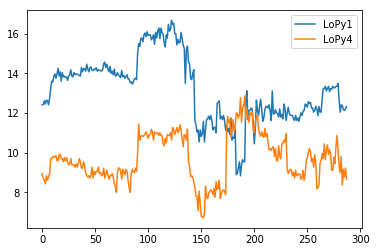

In [662]:
posFeatures = []
negFeatures = []
features = []
labels = []
data1 = []
data4 = []
for feature in range(0,len(lopy1means)):
    posFeatures.append([lopy1means[feature], lopy1medians[feature], lopy1std[feature]])
    data1.append(lopy1std[feature])
    data4.append(lopy4std[feature])
    posFeatures.append([lopy4means[feature], lopy4medians[feature], lopy4std[feature]])
    
    features.append([lopy1means[feature], lopy1medians[feature], lopy1std[feature]])
    labels.append(1)
    features.append([lopy4means[feature], lopy4medians[feature], lopy4std[feature]])
    labels.append(1)
    
    negFeatures.append([rpi1means[feature], rpi1medians[feature], rpi1std[feature]])
    negFeatures.append([lopy6means[feature], lopy6medians[feature], lopy6std[feature]])
    
    features.append([rpi1means[feature], rpi1medians[feature], rpi1std[feature]])
    labels.append(0)
    features.append([lopy6means[feature], lopy6medians[feature], lopy6std[feature]])
    labels.append(0)

features = np.array(features)
labels = np.array(labels)

fig, ax = plt.subplots()
ax.plot(data1, label = 'LoPy1')
ax.plot(data4, label = 'LoPy4')
ax.legend()
print(features.shape, labels.shape)

In [663]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe_lrSVC = Pipeline([('scaler', StandardScaler()), ('clf', LinearSVC())])
pipe_lrSVC.fit(features, labels)
print(pipe_lrSVC.steps[1][1].coef_)
#y_pred = pipe_lrSVC.predict(X_test)

[[0.12235952 3.49216415 0.67294868]]


In [674]:
TEST = []
for hour in range(18,19):
    for minute in range(0,50,5):
        period = (hour*12) + (minute/5) + 1
        test = get5MinStats(lopy3Wifi, hour, minute)
        #print(test)
        val = [test[0], test[1], test[2]]
        TEST.append(val)

TEST = np.array(TEST)
pred = pipe_lrSVC.predict(TEST)
print(pred)

[0 0 0 0 0 0 0 0 0 0]


In [660]:
print(lopy1Wifi.count_documents({ '$and' : [{'Time': {'$gte': '20190304T143500'}}, {'Time': {'$lt': '20190305T143500'}}]}))
print(lopy2Wifi.find_one({ '$and' : [{'Time': {'$gte': '20190226T000000'}}, {'Time': {'$lt': '20190227T000000'}}]}))
print(lopy4Wifi.count_documents({ '$and' : [{'Time': {'$gte': '20190304T143500'}}, {'Time': {'$lt': '20190305T143500'}}]}))
print(lopy6Wifi.count_documents({ '$and' : [{'Time': {'$gte': '20190304T143500'}}, {'Time': {'$lt': '20190305T143500'}}]}))
print(rpi1Wifi.count_documents({ '$and' : [{'Time': {'$gte': '20190304T143500'}}, {'Time': {'$lt': '20190305T143500'}}]}))

2354
{'_id': ObjectId('5c74c8586d88fd1fbe02d8c7'), 'Time': '20190226T160216', 'Networks': ['TelstraD293DF', 'av-wap-ctrl-brm', 'UOW', 'eduroam', 'UOW_COLLEGE', 'Orientation19', 'UOW', 'eduroam', 'UOW_COLLEGE', 'Orientation19', 'Orientation19', 'UOW', 'eduroam', 'UOW_COLLEGE', 'UOW', 'eduroam', 'Orientation19', 'UOW_COLLEGE', 'UOW', 'UOW_COLLEGE', 'Orientation19', 'UOW', 'eduroam', 'UOW_COLLEGE', 'eduroam', 'SMART Building Free Diarrhea', 'AcrossTheCloud'], 'MAC Addresses': ['30918FD293DF', '6892342A53E8', '00D78FB86660', '00D78FB86661', '00D78FB86667', '00D78FB86669', '006BF1026080', '006BF1026081', '006BF1026087', '006BF1026089', '00D78FCA6769', '00D78FCA6760', '00D78FCA6761', '00D78FCA6767', '00D78FFBE400', '00D78FFBE401', '00D78FFBE409', '00D78FFBE407', '00D78FEDEEE0', '00D78FB86CE7', '00D78FB86CE9', '00D78FB86CE0', '00D78FB86CE1', '00D78FEDEEE7', '00D78FEDEEE1', '00223F413226', '703ACB927188'], 'Signal Strengths': [-53, -59, -65, -65, -66, -66, -73, -73, -73, -73, -77, -77, -77, -7

In [193]:
sampleRSSIlopy1 = []
for item in lopy1Wifi.find({ '$and' : [{'Time': {'$gt': '20190307T153000'}}, {'Time': {'$lte': '20190307T160000'}}]}):
    for value in item['Signal Strengths']:
        sampleRSSIlopy1.append(value)
sampleRSSIlopy1 = np.asarray(sorted(sampleRSSIlopy1, reverse=True))

sampleRSSIlopy2 = []
for item in lopy2Wifi.find({ '$and' : [{'Time': {'$gt': '20190307T153000'}}, {'Time': {'$lte': '20190307T160000'}}]}):
    for value in item['Signal Strengths']:
        sampleRSSIlopy2.append(value)
sampleRSSIlopy2 = np.asarray(sorted(sampleRSSIlopy2, reverse=True))

sampleRSSIlopy4 = []
for item in lopy4Wifi.find({ '$and' : [{'Time': {'$gt': '20190307T153000'}}, {'Time': {'$lte': '20190307T160000'}}]}):
    for value in item['Signal Strengths']:
        sampleRSSIlopy4.append(value)
sampleRSSIlopy4 = np.asarray(sorted(sampleRSSIlopy4, reverse=True))

sampleRSSIlopy5 = []
for item in lopy5Wifi.find({ '$and' : [{'Time': {'$gt': '20190307T153000'}}, {'Time': {'$lte': '20190307T160000'}}]}):
    for value in item['Signal Strengths']:
        sampleRSSIlopy5.append(value)
sampleRSSIlopy5 = np.asarray(sorted(sampleRSSIlopy5, reverse=True))

sampleRSSIlopy6 = []
for item in lopy6Wifi.find({ '$and' : [{'Time': {'$gt': '20190307T153000'}}, {'Time': {'$lte': '20190307T160000'}}]}):
    for value in item['Signal Strengths']:
        sampleRSSIlopy6.append(value)
sampleRSSIlopy6 = np.asarray(sorted(sampleRSSIlopy6, reverse=True))

sampleRSSIrpi1 = []
for item in rpi1Wifi.find({ '$and' : [{'Time': {'$gt': '20190307T153000'}}, {'Time': {'$lte': '20190307T160000'}}]}):
    for value in item['Signal Strengths']:
        sampleRSSIrpi1.append(value)
sampleRSSIrpi1 = np.asarray(sorted(sampleRSSIrpi1, reverse=True))

In [186]:
#print(normlopy1)
normlopy1 = sampleRSSIlopy1 - sampleRSSIlopy1.min()
normlopy1 = normlopy1/normlopy1.max()
#print(normlopy1)
#normlopy2 = sampleRSSIlopy2 - sampleRSSIlopy2.min()
#normlopy2 = normlopy2/normlopy2.max()
normlopy4 = sampleRSSIlopy4 - sampleRSSIlopy4.min()
normlopy4 = normlopy4/normlopy4.max()
normlopy6 = sampleRSSIlopy6 - sampleRSSIlopy6.min()
normlopy6 = normlopy6/normlopy6.max()
#normrpi1 = sampleRSSIrpi1 - sampleRSSIrpi1.min()
#normrpi1 = normrpi1/normrpi1.max()

In [199]:
normlopy1 = stats.trim1(sampleRSSIlopy1, 0.05, tail = 'left')
#normlopy2 = stats.trim1(normlopy2, 0.05, tail = 'left')
normlopy4 = stats.trim1(sampleRSSIlopy4, 0.05, tail = 'left')
normlopy5 = stats.trim1(sampleRSSIlopy5, 0.05, tail = 'left')
normlopy6 = stats.trim1(sampleRSSIlopy6, 0.05, tail = 'left')
normrpi1 = stats.trim1(sampleRSSIrpi1, 0.05, tail = 'left')

In [200]:
print('LoPy1:')
print('Number of data points = %d, Mean = %f, Median = %f, Std. Dev. = %f, Variance = %f' %(len(normlopy1), mean(normlopy1), 
                                                                           median(normlopy1),  
                                                                           stdev(normlopy1), variance(normlopy1)))
print('LoPy2:')
#print('Number of data points = %d, Mean = %f, Median = %f, Std. Dev. = %f, Variance = %f' %(len(normlopy2), mean(normlopy2), 
                                                                           #median(normlopy2),  
                                                                           #stdev(normlopy2), variance(normlopy2)))
print('LoPy4:')
print('Number of data points = %d, Mean = %f, Median = %f, Std. Dev. = %f, Variance = %f' %(len(normlopy4), mean(normlopy4), 
                                                                           median(normlopy4),  
                                                                           stdev(normlopy4), variance(normlopy4)))
print('LoPy5:')
print('Number of data points = %d, Mean = %f, Median = %f, Std. Dev. = %f, Variance = %f' %(len(normlopy5), mean(normlopy5), 
                                                                           median(normlopy5),  
                                                                           stdev(normlopy5), variance(normlopy5)))
print('LoPy6:')
#print('Number of data points = %d, Mean = %f, Median = %f, Std. Dev. = %f, Variance = %f' %(len(normlopy6), mean(normlopy6), 
                                                                           #median(normlopy6), 
                                                                           #stdev(normlopy6), variance(normlopy6)))
print('RPi1:')
print('Number of data points = %d, Mean = %f, Median = %f, Std. Dev. = %f, Variance = %f' %(len(normrpi1), mean(normrpi1), 
                                                                           median(normrpi1),  
                                                                           stdev(normrpi1), variance(normrpi1)))

LoPy1:
Number of data points = 995, Mean = -75.000000, Median = -81.000000, Std. Dev. = 12.124356, Variance = 147.000000
LoPy2:
LoPy4:
Number of data points = 1652, Mean = -77.000000, Median = -82.000000, Std. Dev. = 10.198039, Variance = 104.000000
LoPy5:
Number of data points = 1824, Mean = -73.000000, Median = -72.000000, Std. Dev. = 7.937254, Variance = 63.000000
LoPy6:
RPi1:
Number of data points = 742, Mean = -72.000000, Median = -79.000000, Std. Dev. = 15.556349, Variance = 242.000000


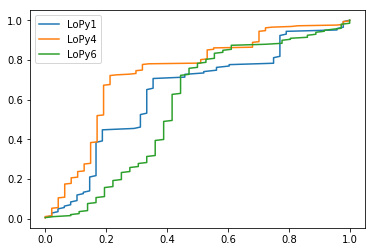

In [419]:
ecdf1 = ECDF(normlopy1)
#ecdf2 = ECDF(normlopy2)
ecdf4 = ECDF(normlopy4)
ecdf6 = ECDF(normlopy6)
#ecdfpi = ECDF(normrpi1)
fig, ax = plt.subplots()
ax.plot(ecdf1.x, ecdf1.y, label = 'LoPy1')
#ax.plot(ecdf2.x, ecdf2.y, label = 'LoPy2')
ax.plot(ecdf4.x, ecdf4.y, label = 'LoPy4')
ax.plot(ecdf6.x, ecdf6.y, label = 'LoPy6')
#ax.plot(ecdfpi.x, ecdfpi.y, label = 'RPi1')
ax.legend()

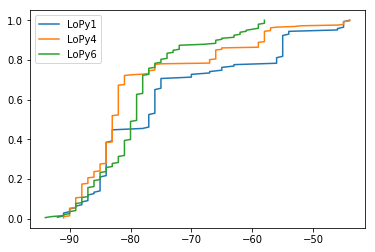

In [418]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf1 = ECDF(sampleRSSIlopy1)
#ecdf2 = ECDF(sampleRSSIlopy2)
ecdf4 = ECDF(sampleRSSIlopy4)
ecdf6 = ECDF(sampleRSSIlopy6)
#ecdfpi = ECDF(sampleRSSIrpi1)
fig, ax = plt.subplots()
ax.plot(ecdf1.x, ecdf1.y, label = 'LoPy1')
#ax.plot(ecdf2.x, ecdf2.y, label = 'LoPy2')
ax.plot(ecdf4.x, ecdf4.y, label = 'LoPy4')
ax.plot(ecdf6.x, ecdf6.y, label = 'LoPy6')
#ax.plot(ecdfpi.x, ecdfpi.y, label = 'RPi1')
ax.legend()

In [96]:
import scipy.integrate as integrate

result1 = integrate.quad(ecdf1, -np.inf, np.inf)
result4 = integrate.quad(ecdf4, -np.inf, np.inf)
print(result1)
print(result4)

(78.42196294876433, 1.8015607437456111)
(86.54037997746786, 10.910235929757363)


/home/clifford/summer/lib/python3.6/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/clifford/summer/lib/python3.6/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  after removing the cwd from sys.path.


In [59]:
stats.ks_2samp(sampleRSSIlopy1, sampleRSSIlopy2)

Ks_2sampResult(statistic=0.18758853655878827, pvalue=0.0027967800028731887)

In [654]:
def kde_scipy(x, x_grid, bandwidth, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

grid1 = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(1, 5, 10)},cv=20) # 20-fold cross-validation
grid1.fit(sampleRSSI1[:, None])
print(grid1.best_params_)
kde1 = grid1.best_estimator_
print(kde1)

grid2 = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(1, 5, 10)},cv=20) # 20-fold cross-validation
grid2.fit(sampleRSSI2[:, None])
print(grid2.best_params_)
kde2 = grid2.best_estimator_
print(kde2)

/home/clifford/summer/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bandwidth': 4.555555555555555}
KernelDensity(algorithm='auto', atol=0, bandwidth=4.555555555555555,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0)
{'bandwidth': 2.333333333333333}
KernelDensity(algorithm='auto', atol=0, bandwidth=2.333333333333333,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0)


/home/clifford/summer/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


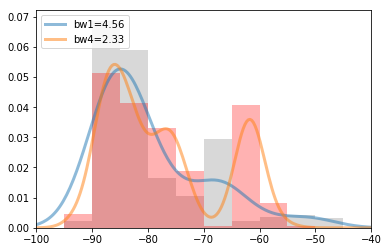

In [655]:
x_grid = np.linspace(-100, -40, 200)

pdf1 = np.exp(kde1.score_samples(x_grid[:, None]))
pdf2 = np.exp(kde2.score_samples(x_grid[:, None]))

fig, ax = plt.subplots()
ax.plot(x_grid, pdf1, linewidth=3, alpha=0.5, label='bw1=%.2f' % kde1.bandwidth)
ax.plot(x_grid, pdf2, linewidth=3, alpha=0.5, label='bw4=%.2f' % kde2.bandwidth)
ax.hist(sampleRSSI1, [-100,-95,-90,-85,-80,-75,-70,-65,-60,-55,-50,-45,-40], fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.hist(sampleRSSI2, [-100,-95,-90,-85,-80,-75,-70,-65,-60,-55,-50,-45,-40], fc='red', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')
ax.set_xlim(-100, -40);

(-100, -40)

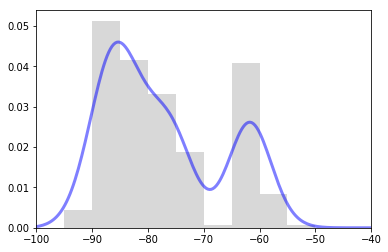

In [658]:
fig, ax = plt.subplots()
pdf = kde_scipy(sampleRSSI2, x_grid, bandwidth = 3.5)
ax.plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
ax.hist(sampleRSSI2, [-100,-95,-90,-85,-80,-75,-70,-65,-60,-55,-50,-45,-40], fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(-100, -40)

In [597]:
previous = []
startTime = 95000
endTime = 100000
end = 110000
device = lopy1Wifi
numUnique = []
time = []
for item in device.find({ '$and' : [{'Time': {'$gt': '20190227T0' + str(startTime)}}, {'Time': {'$lte': '20190227T' + str(endTime)}}]}):
    for network in item['MAC Addresses']:
        if network not in  previous:
            previous.append(network)
time.append(':'.join(str(endTime)[i:i+2] for i in range(0, len(str(endTime)), 2)))

for period in range(1,6):
    current = []
    unique = []
    names = []
    startTime = endTime
    endTime += 1000
    for item in device.find({ '$and' : [{'Time': {'$gt': '20190227T' + str(startTime)}}, {'Time': {'$lte': '20190227T' + str(endTime)}}]}):
        for network in item['MAC Addresses']:
            if network not in  current:
                current.append(network)
                if network not in  previous:
                    unique.append(network)
                    pos = item['MAC Addresses'].index(network)
                    names.append(item['Networks'][pos])
    previous = current
    print('%d unique network(s) in period %d: ' %(len(unique),period), unique, names)
    numUnique.append(len(unique))
    time.append(':'.join(str(endTime)[i:i+2] for i in range(0, len(str(endTime)), 2)))

current = []
unique = []
names = []
for item in device.find({ '$and' : [{'Time': {'$gt': '20190227T' + str(endTime)}}, {'Time': {'$lte': '20190227T' + str(end)}}]}):
    for network in item['MAC Addresses']:
        if network not in  current:
            current.append(network)
            if network not in  previous:
                unique.append(network)
                pos = item['MAC Addresses'].index(network)
                names.append(item['Networks'][pos])
print('%d unique network(s) in period %d: ' %(len(unique),period + 1), unique, names)
numUnique.append(len(unique))
#print(numUnique)
time.append(':'.join(str(end)[i:i+2] for i in range(0, len(str(end)), 2)))
#print(time)



0 unique network(s) in period 1:  [] []
1 unique network(s) in period 2:  ['900628CB3509'] ['AndroidAP']
1 unique network(s) in period 3:  ['AE8EF2BAF1F5'] ['iPhone']
0 unique network(s) in period 4:  [] []
3 unique network(s) in period 5:  ['00D78FC22921', '00D78FC22927', 'A4CAA0360B58'] ['eduroam', 'UOW_COLLEGE', 'ST WIFI']
0 unique network(s) in period 6:  [] []


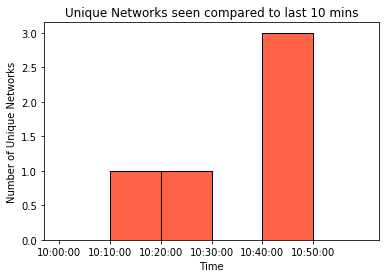

In [598]:
fig, ax = plt.subplots()
index = np.arange(6)
bar_width = 1.0

rects1 = ax.bar(index, numUnique, bar_width, edgecolor = 'black', color='tomato', align = 'edge')

ax.set_xlabel('Time')
ax.set_ylabel('Number of Unique Networks')
ax.set_title('Unique Networks seen compared to last 10 mins')
ax.tick_params('x', width = 0.8)
ax.set_xticks(index)
ax.set_xticklabels(time)


plt.show()

In [294]:
lopy6Wifi = client.SMART.WiFi_Data_Lopy4
myquery = { '$and' : [{'Time': {'$gt': '20190226T122114'}}, {'Time': {'$lte': '20190226T161700'}}]}

x = lopy6Wifi.delete_many(myquery)

print(x.deleted_count, " documents deleted.")

0  documents deleted.
